In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer
import joblib

In [2]:
df = pd.read_csv("SalaryData.csv")
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,City Tier,Remote Work,Industry
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0,Canada,Tier 3,Yes,Tech
1,28.0,Female,Master's,Data Analyst,3.0,65000.0,UK,Tier 1,Yes,Data
2,45.0,Male,PhD,Senior Manager,15.0,150000.0,Germany,Tier 2,No,Management
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0,UK,Tier 1,No,Sales
4,52.0,Male,Master's,Director,20.0,200000.0,UK,Tier 2,Yes,Other


In [3]:
df.tail()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,City Tier,Remote Work,Industry
6693,49.0,Female,PhD,Director of Marketing,20.0,200000.0,Germany,Tier 1,Yes,Other
6694,32.0,Male,High School,Sales Associate,3.0,50000.0,Australia,Tier 1,Yes,Sales
6695,30.0,Female,Bachelor's Degree,Financial Manager,4.0,55000.0,Australia,Tier 1,Yes,Management
6696,46.0,Male,Master's Degree,Marketing Manager,14.0,140000.0,Germany,Tier 2,No,Management
6697,26.0,Female,High School,Sales Executive,1.0,35000.0,India,Tier 1,No,Sales


In [4]:
print("Dataset Rows And Columns:", df.shape)

Dataset Rows And Columns: (6698, 10)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6698 entries, 0 to 6697
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6698 non-null   float64
 1   Gender               6698 non-null   object 
 2   Education Level      6698 non-null   object 
 3   Job Title            6698 non-null   object 
 4   Years of Experience  6698 non-null   float64
 5   Salary               6698 non-null   float64
 6   Country              6698 non-null   object 
 7   City Tier            6698 non-null   object 
 8   Remote Work          6698 non-null   object 
 9   Industry             6698 non-null   object 
dtypes: float64(3), object(7)
memory usage: 523.4+ KB


In [6]:
df.isnull()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,City Tier,Remote Work,Industry
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
6693,False,False,False,False,False,False,False,False,False,False
6694,False,False,False,False,False,False,False,False,False,False
6695,False,False,False,False,False,False,False,False,False,False
6696,False,False,False,False,False,False,False,False,False,False


In [7]:
df.isnull().sum()

Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
Country                0
City Tier              0
Remote Work            0
Industry               0
dtype: int64

In [8]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
6693     True
6694     True
6695    False
6696    False
6697    False
Length: 6698, dtype: bool

In [9]:
df.duplicated().sum()

np.int64(980)

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.duplicated().sum()

np.int64(0)

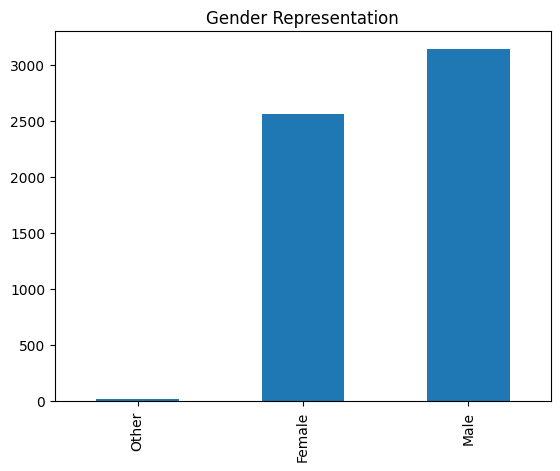

In [12]:
df["Gender"].value_counts().sort_values(ascending=True).plot(kind="bar")
plt.title("Gender Representation")
plt.xlabel("")
plt.show()

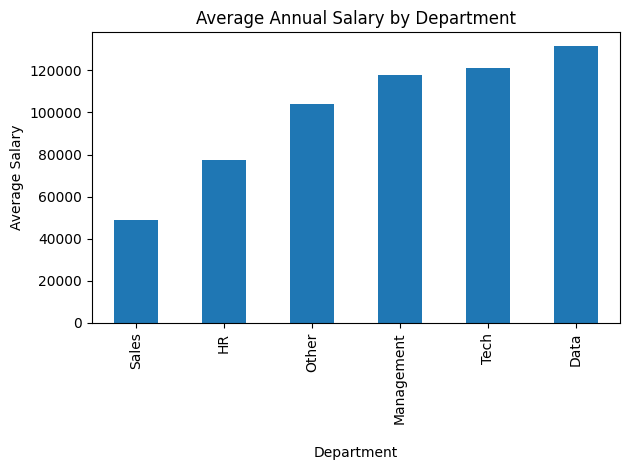

In [13]:
df.groupby("Industry")["Salary"].mean().sort_values(ascending=True).plot(kind="bar")
plt.title("Average Annual Salary by Department")
plt.ylabel("Average Salary") 
plt.xlabel("\nDepartment") 
plt.tight_layout()
plt.show()

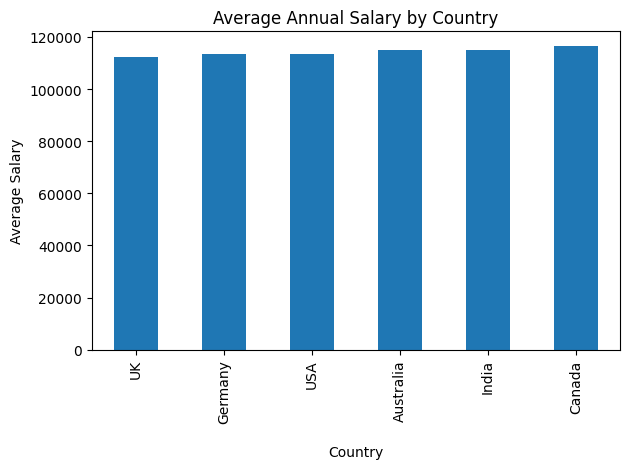

In [14]:
df.groupby("Country")["Salary"].mean().sort_values(ascending=True).plot(kind="bar")
plt.title("Average Annual Salary by Country")
plt.ylabel("Average Salary") 
plt.xlabel("\nCountry") 
plt.tight_layout()
plt.show()

In [15]:
df['Salary'].describe()

count      5718.000000
mean     114333.487058
std       52602.322623
min         350.000000
25%       70000.000000
50%      113926.500000
75%      160000.000000
max      250000.000000
Name: Salary, dtype: float64

In [16]:
df = df[df['Education Level'] != 'High School']

In [17]:
df['Education Level'] = df['Education Level'].replace({
    "Bachelor's Degree": "Bachelor's",
    "Master's Degree": "Master's",
    "phD": "PhD"
})
df['Education Level'].unique()

array(["Bachelor's", "Master's", 'PhD'], dtype=object)

In [18]:
df = df[(df['Years of Experience'] <= 40) & (df['Age'] - df['Years of Experience'] >= 17)]
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

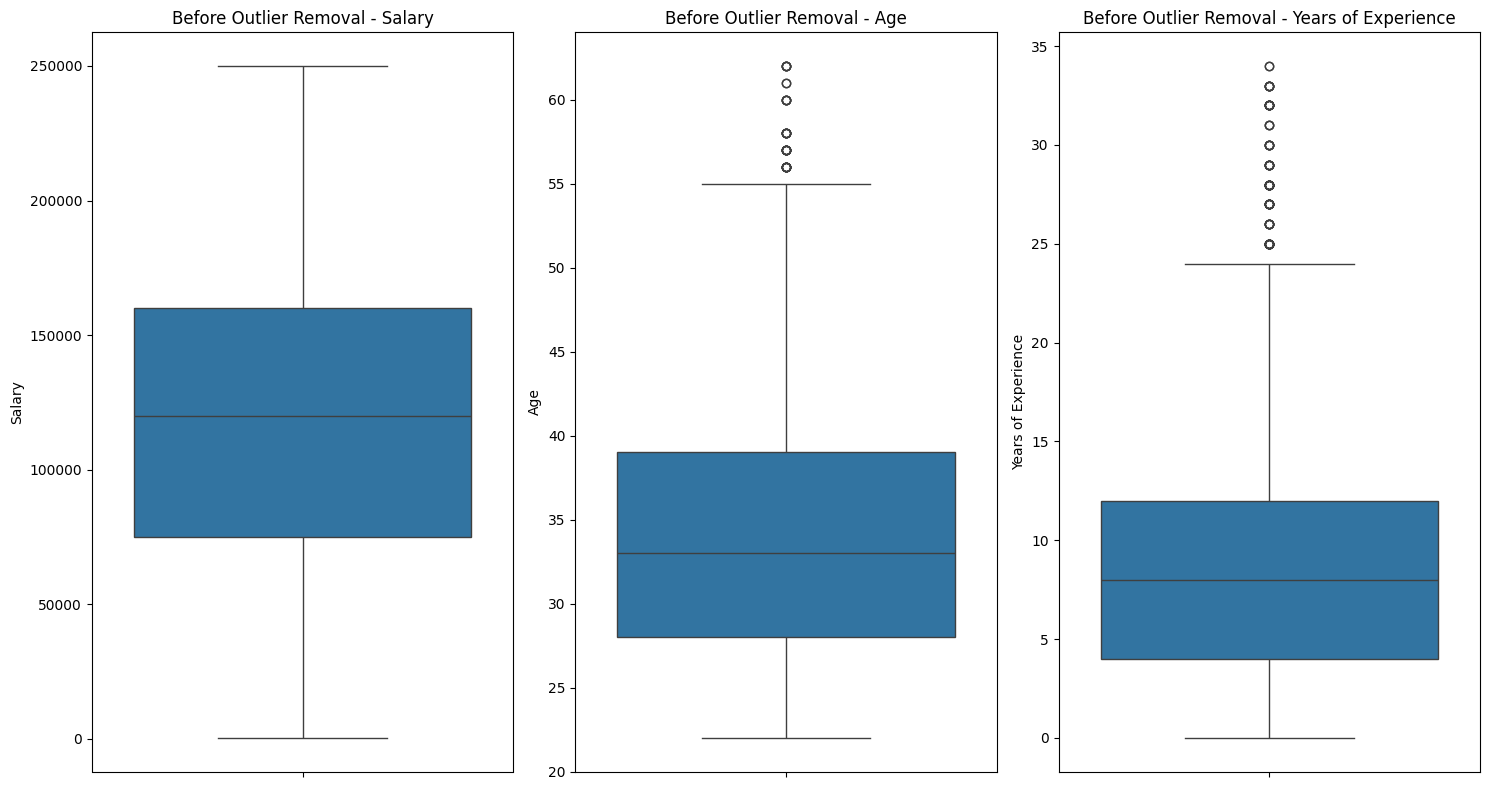

In [19]:
#Outliers
plt.figure(figsize=(15, 8))
for i, col in enumerate(["Salary", "Age", "Years of Experience"]):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f"Before Outlier Removal - {col}")
plt.tight_layout()
plt.show()

In [20]:
for col in ["Salary", "Age", "Years of Experience"]:
    df = remove_outliers_iqr(df, col)

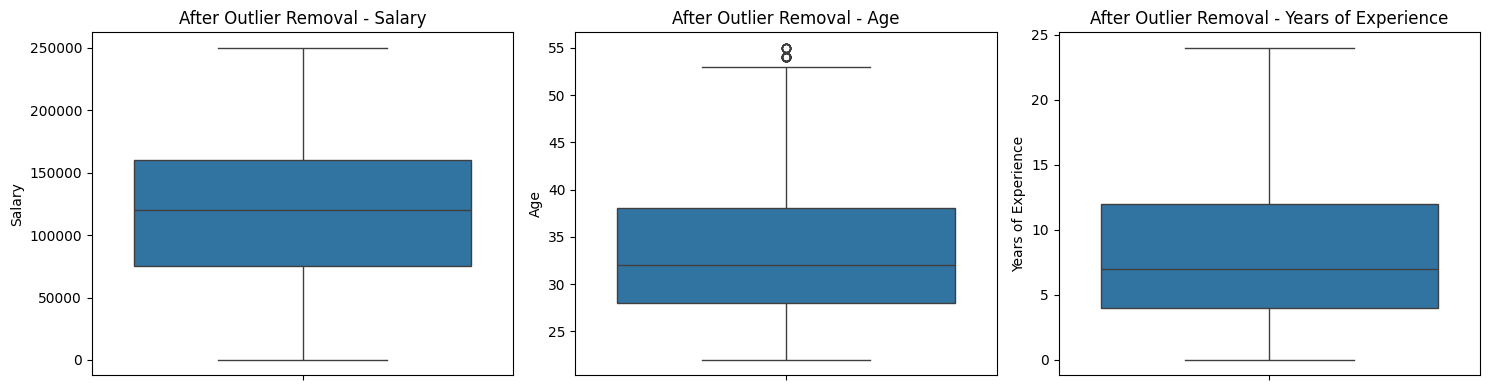

In [21]:
#Removing outliers
plt.figure(figsize=(15, 4))
for i, col in enumerate(["Salary", "Age", "Years of Experience"]):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f"After Outlier Removal - {col}")
plt.tight_layout()
plt.show()

In [22]:
categorical_cols = ["Gender", "Education Level", "Job Title", "Country", "City Tier", "Remote Work", "Industry"]
numerical_cols = ["Age", "Years of Experience"]

X = df[categorical_cols + numerical_cols]
y = df["Salary"]

In [23]:
preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
    ("scale", StandardScaler(), numerical_cols)
])

In [28]:
#ml-models
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
models = {
    "RandomForest": RandomForestRegressor(),
    "KNN": KNeighborsRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "DecisionTree": DecisionTreeRegressor()
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
results = {}
pipelines = {}

for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results[name] = {
        "R2": r2,
        "MAE": mae,
        "RMSE": rmse
    }
    pipelines[name] = pipe

    print(f"\n🔷 {name}")
    print(f"R²:   {r2:.4f}")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")



🔷 RandomForest
R²:   0.9529
MAE:  4810.07
RMSE: 10765.97

🔷 KNN
R²:   0.8538
MAE:  12605.18
RMSE: 18974.27

🔷 GradientBoosting
R²:   0.8856
MAE:  12145.17
RMSE: 16786.12

🔷 DecisionTree
R²:   0.9356
MAE:  4809.34
RMSE: 12594.45


In [29]:
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="R2", ascending=False)
results_df.to_csv("model_comparison.csv")

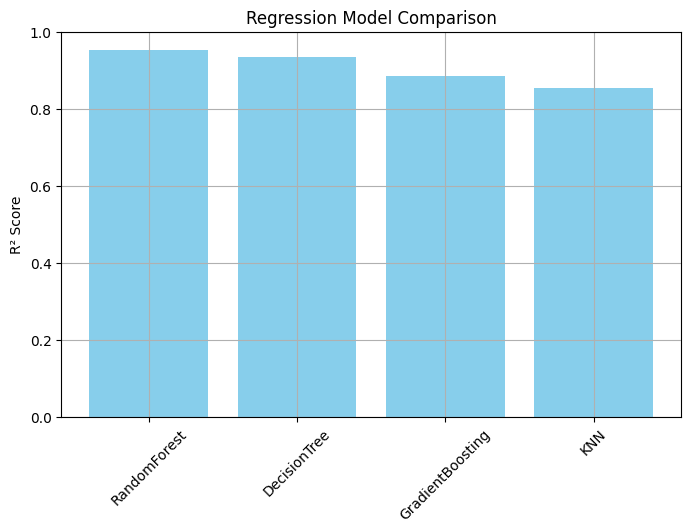

In [30]:
plt.figure(figsize=(8, 5))
plt.bar(results_df.index, results_df["R2"], color='skyblue')
plt.ylabel("R² Score")
plt.title("Regression Model Comparison")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [31]:
best_model_name = results_df["R2"].idxmax()
best_model = pipelines[best_model_name]
joblib.dump(best_model, "best_regression_model.pkl")
print(f"\nBest model: {best_model_name} (R² = {results_df.loc[best_model_name, 'R2']:.4f})")
print("Saved as best_regression_model.pkl")


Best model: RandomForest (R² = 0.9529)
Saved as best_regression_model.pkl
